<a href="https://colab.research.google.com/github/alsh626626/CE888/blob/main/Lab_4/my_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)

Load the data from ``jester-data-1.csv''

*   The data is from http://eigentaste.berkeley.edu/dataset/ and it contains the ratings of 100 jokes from 11,190 users
*   Check the dataset description to figure out which value you should replace with NaNs (the cells for which we don't have a rating). This is the test set.
*   To replace values when you load, you can find help here: https://stackoverflow.com/questions/29247712/how-to-replace-a-value-in-pandas-with-nan
*   There's a column you need to remove because it doesn't contain ratings. Check the description of the dataset and figure out which one. Then drop it.



In [2]:
# Ratings are real values ranging from -10.00 to +10.00 (the value "99" corresponds to "null" = "not rated")
df = pd.read_csv("https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv", header=None, na_values=[99])

In [3]:
# The first column gives the number of jokes rated by that user. The next 100 columns give the ratings for jokes 01 - 100
df.drop(columns=0, inplace=True)
df_test = df.copy()
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,7.48,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,7.33,NaN,6.17,9.08,7.33,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,2.82,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [4]:
df.shape

(24983, 100)

Use pandas to find the best- and the worst-rated jokes


In [5]:
df_melt = df.melt(var_name="Joke", value_name="Rating")
df_melt = df_melt.groupby(by='Joke').agg({'Rating':'mean'})
df_melt = df_melt.sort_values(by=['Rating'], ascending=False)

In [6]:
df_melt

,Rating
Joke,
50,3.665085
89,3.574720
36,3.312500
27,3.189821
32,3.155988
...,...
13,-1.762882
57,-1.990664
44,-2.111891


Modify and use the helper function provided in the helper_function notebook (or create your own) to label 10% of the dataset cells that are not NaNs as 99. This is your validation set. Keep the the actual values of the cells so you can use them later (as done in the example of the helper_function notebook).

In [7]:
df = df.fillna(99)
arr = df.values
print(arr.shape)

(24983, 100)


In [8]:
rated = np.where(arr!=99)
print(len(rated[0]), rated[1].shape)

1810455 (1810455,)


In [9]:
def replace(orig, percentage=0.1):
  """
  Replaces 'percentage'% of the original values in 'orig' with 99's
  :param orig: original data array
  :param percentage: percentage of values to replace (0<percentage<1)
  """
  new_data = orig.copy()
  rated = np.where(arr!=99)
  n_rated = len(rated[0])
  idx = np.random.choice(n_rated, size=int(percentage*n_rated), replace=False)
  new_data[rated[0][idx], rated[1][idx]] = 99
  return new_data, (rated[0][idx], rated[1][idx])

In [10]:
new_arr, idx = replace(arr, 0.1)

In [11]:
arr[idx[0][0], idx[1][0]]

9.03

In [12]:
new_arr[idx[0][0], idx[1][0]]

99.0

Use latent factor modeling (with 2 latent factors) to infer the hidden ratings of the users (they are labeled as "99" in the dataset) on the training set. You will have to modify at least one line in the provided sgd() function for this (and probably 2, depending on your variable names).

*   Iterations in sgd will take a long time to run: you can (and should) use low numbers. Try something like 10.
*   You can interrupt at any point the execution of this function, because the values are updated in each iteration, so if you interrupt execution you can use the latent_user_preferences and latent_item_features.



In [13]:
n_latent_factors = 2

user_ratings = new_arr
# Initialise as random values
latent_user_preferences = np.random.random((user_ratings.shape[0], n_latent_factors))
latent_item_features = np.random.random((user_ratings.shape[1], n_latent_factors))

In [14]:
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)


def train(user_id, item_id, rating, alpha=0.0001):
    #print(item_id)
    predicted_rating = predict_rating(user_id, item_id)
    err =  predicted_rating - rating
    #print(err)
    user_pref_values = latent_user_preferences[user_id]
    latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
    latent_item_features[item_id] -= alpha * err * user_pref_values
    return err
    

def sgd(iterations):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    mse_history = []
    for iteration in range(iterations):
        error = []
        for user_id in range(latent_user_preferences.shape[0]):
            for item_id in range(latent_item_features.shape[0]):
                rating = user_ratings[user_id, item_id]
                if not np.isnan(rating):
                  if rating != 99:
                    err = train(user_id, item_id, rating)
                    error.append(err)
        mse = (np.array(error) ** 2).mean()   
        if (iteration % 1) == 0:
            print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse))
            mse_history.append(mse)
    return mse_history

Calculate the performance (e.g., MSE) of the algorithm on the validation dataset

Iteration 0/10:	MSE=26.176000
Iteration 1/10:	MSE=25.246062
Iteration 2/10:	MSE=24.959316
Iteration 3/10:	MSE=24.741647
Iteration 4/10:	MSE=24.531054
Iteration 5/10:	MSE=24.319110
Iteration 6/10:	MSE=24.105031
Iteration 7/10:	MSE=23.889628
Iteration 8/10:	MSE=23.674160
Iteration 9/10:	MSE=23.460023


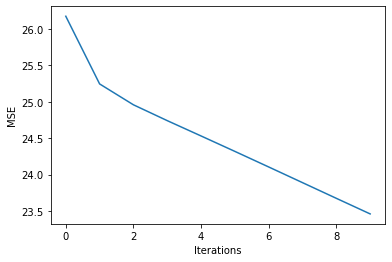

In [15]:
num_iter = 10
hist = sgd(num_iter)  # Note how the MSE decreases with the number of iterations
plt.figure()
plt.plot(np.arange(0, num_iter, 1), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

Make predictions for the test dataset.

In [16]:
predictions = latent_user_preferences.dot(latent_item_features.T)
predictions

array([[1.102, 0.671, 0.671, ..., 1.242, 0.487, 1.739],
       [0.659, 0.405, 0.395, ..., 0.748, 0.288, 1.072],
       [1.492, 0.898, 0.926, ..., 1.669, 0.668, 2.267],
       ...,
       [1.41 , 0.848, 0.877, ..., 1.576, 0.632, 2.136],
       [1.865, 1.12 , 1.161, ..., 2.083, 0.836, 2.815],
       [1.181, 0.708, 0.738, ..., 1.317, 0.531, 1.768]])

In [17]:
user_ratings = df_test.values
values = [zip(user_ratings[i], predictions[i]) for i in range(predictions.shape[0])]
comparison_data = pd.DataFrame(values)
comparison_data.columns = df.columns

In [18]:
comparison_data
# For each data point, the number on the left is the original value from the dataset, the number on the right is the prediction

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,"(-7.82, 1.1015923707762816)","(8.79, 0.6713097859404681)","(-9.66, 0.6710378371284746)","(-8.16, -0.6739359697629491)","(-7.52, 0.7426152169585344)","(-8.5, 1.8608110859909546)","(-9.85, -0.07073003695362019)","(4.17, -0.3381145418166239)","(-8.98, -0.0418052521927328)","(-4.76, 1.4192832763427652)","(-8.5, 2.0370352617216727)","(-6.75, 1.8886429969825616)","(-7.18, -1.3539303874516313)","(8.45, 1.8396412902833204)","(-7.18, -1.3230776447753976)","(-7.52, -2.4727082742682107)","(-7.43, -0.6133120084296199)","(-9.81, -0.3358733243176276)","(-9.85, 0.49680617360634516)","(-9.85, -0.39952147763922924)","(-9.37, 2.426532572470106)","(1.5, 1.2799383481449278)","(-4.37, 0.5617168345256742)","(-9.81, -1.0027792723114248)","(-8.5, 0.9148977795238239)","(1.12, 1.76328007060898)","(7.82, 3.165824279594289)","(2.86, 1.815741904323122)","(9.13, 2.9758961276527547)","(-7.43, 0.20089874631132063)","(2.14, 2.466034445454803)","(-4.08, 3.127487145924573)","(-9.08, -0.6130533920757252)","(7.82, 1.3832381428702727)","(5.05, 3.060444354539857)","(4.95, 3.2139259652526633)","(-9.17, -0.7814530509919395)","(-8.4, 1.5325300670611066)","(-8.4, 1.5607280251779347)","(-8.4, 1.463102771244711)",...,"(8.59, 2.69024293680202)","(3.59, 3.0198496025557477)","(-6.84, 0.7840544971979477)","(-9.03, -0.1322033917993184)","(2.82, 2.583830609301674)","(-1.36, 2.692313625006328)","(-9.08, -0.25717305229654663)","(8.3, 2.756692897516278)","(5.68, 2.773395099386728)","(-4.81, 0.9684798535892658)","(nan, -0.12041043453477691)","(nan, 2.793159188756408)","(nan, 1.4508588750933515)","(nan, -0.7464801121155937)","(nan, 0.2974360216615271)","(nan, 2.507658348811721)","(nan, 1.1671270677298073)","(-9.42, 1.981444916746867)","(nan, 0.7497239722775053)","(nan, 1.5631790269580845)","(nan, 1.998631639242393)","(-7.72, 1.2187732360418664)","(nan, 2.23326069865714)","(nan, 1.1135776548420442)","(nan, 1.3209213850217174)","(nan, 0.63382855372298)","(nan, 2.01760397042209)","(nan, 2.1675363780794474)","(nan, 3.359009722558639)","(nan, 1.0544550733548919)","(2.82, 2.103549298503663)","(nan, 1.4831304715210039)","(nan, 2.525192942381846)","(nan, 1.3728229437414958)","(nan, 1.321458022470691)","(nan, 1.7338850309687925)","(-5.63, 1.8297055931311685)","(nan, 1.2422116984047518)","(nan, 0.4867311228723464)","(nan, 1.7389734467850821)"
1,"(4.08, 0.658531602931492)","(-0.29, 0.4054188109190083)","(6.36, 0.394705903462076)","(4.37, -0.3990278661471987)","(-2.38, 0.45560113916665274)","(-9.66, 1.1151043836306838)","(-0.73, -0.06323453348801894)","(-5.34, -0.21049300576328722)","(8.88, -0.012885182264916924)","(9.22, 0.8640896683957091)","(6.75, 1.2394897677234316)","(8.64, 1.1550059050440327)","(4.42, -0.8478032835898895)","(7.43, 1.1242471590690313)","(4.56, -0.7944429865744462)","(-0.97, -1.5102420329694535)","(4.66, -0.36310766607117234)","(-0.68, -0.2076221576440753)","(3.3, 0.2987591131855402)","(-1.21, -0.24562609679964226)","(0.87, 1.4952515836492677)","(8.64, 0.7959142908165874)","(8.35, 0.3331265911916221)","(9.17, -0.5825908037551274)","(0.05, 0.5666823979084752)","(7.57, 1.1004748131950992)","(4.71, 1.9252829110757672)","(0.87, 1.0960190930608094)","(-0.39, 1.8083616944824805)","(6.99, 0.13020267831978388)","(6.5, 1.5086570880037204)","(-0.92, 1.8907057373165723)","(7.14, -0.37314366011667843)","(9.03, 0.8507777404391683)","(-1.8, 1.8733146097254618)","(0.73, 1.9546066526391779)","(7.09, -0.4910255909221614)","(3.4, 0.9352918948174148)","(-0.87, 0.9566344592562055)","(7.91, 0.9044153771240193)",...,"(-6.7, 1.6478281198260094)","(-3.35, 1.840215510424562)","(-9.03, 0.4809207379086271)","(4.47, -0.07760044312132394)","(4.08, 1.5971940515569107)","(-3.83, 1.6433419021491105)","(8.74, -0.1485177191612534)","(1.12, 1.685126330205847)","(0.78, 1.6

# Unit 4 lab quiz


In [19]:
df.iloc[3416, 8]

4.17

In [21]:
file_name = 'movies_latent_factors.xlsx'
df_Items = pd.read_excel(file_name, sheet_name='Items')
df_Users = pd.read_excel(file_name, sheet_name='Users')

In [23]:
df_Items_dot = df_Items.iloc[:,2:].T
df_Users_dot = df_Users.drop(df_Users.columns[0], axis=1)

df_dot = df_Users_dot.dot(df_Items_dot)
df_dot.columns = df_Items['Movie ID'].tolist()
df_dot.index = df_Users['User'].tolist()

In [24]:
df_dot

,11,12,13,14,22,24,38,63,77,85,98,105,107,114,120,121,122,134,141,146,153,155,161,180,187,194,197,238,243,268,272,274,275,278,280,329,393,414,424,453,...,745,752,786,788,807,808,809,812,854,857,862,954,955,1422,1572,1597,1637,1891,1892,1894,1900,2024,2164,2501,2502,3049,4327,5503,7443,8358,8467,8587,9331,9741,9802,9806,10020,36657,36658,36955
4768,0.389174,0.191449,0.766364,-0.190918,-0.610322,-0.388917,-0.004002,0.190730,0.268826,1.188110,0.195472,1.075866,0.490713,-0.514578,-0.370327,-0.506850,-0.416795,0.263785,0.069576,-0.461273,-0.168938,0.248981,-0.088369,-0.320207,-0.171628,0.058226,0.287472,0.634223,0.216470,-0.269254,-0.023449,0.532674,0.471114,0.937787,0.414122,0.243899,-0.465304,-1.140411,0.593612,0.080442,...,0.366176,-0.402584,0.050475,0.149423,0.541162,0.661988,0.055876,-0.112212,-0.039461,0.450075,0.525795,-0.361932,-1.052730,0.378917,0.237825,0.309767,-0.154147,0.416629,0.304657,-1.417385,0.061697,-0.266492,-0.079663,0.543639,0.341835,0.129791,-1.246529,0.567501,-0.031013,0.077461,0.526472,-0.053100,0.116875,-0.167823,0.207883,0.248880,-0.264199,-0.395129,-0.522412,0.097010
156,0.883069,0.319496,0.396485,-0.380979,-0.187145,-0.862520,-0.119464,-0.044719,0.082417,0.345774,0.658106,0.510767,-0.125068,-0.151969,0.517930,0.472757,0.561092,-0.221019,-0.129598,-0.208213,-0.225939,0.702483,0.189687,0.337877,-0.260572,-0.292796,0.404124,-0.049005,-0.129483,-0.550813,0.336472,-0.119816,-0.242805,0.293419,0.268176,0.577851,-0.884860,-1.023764,0.199863,0.514953,...,0.304296,0.409391,-0.229632,-0.136578,-0.101327,-0.106959,-0.488648,-0.003041,-0.561891,0.251416,0.269787,0.052700,-0.328004,0.046813,0.016504,-0.218339,-0.111493,0.910234,0.885208,0.409308,-0.218698,0.033565,0.277388,0.277319,0.220398,-0.637950,-1.423655,0.097996,-0.354999,0.122281,-0.500473,0.357837,-0.041433,-0.072079,0.048516,0.062227,-0.179019,-0.259385,-0.455462,-0.113381
5323,0.214068,0.154537,0.261073,-0.187174,0.502264,0.447514,-0.258614,-0.293113,-0.104059,0.073767,0.543291,0.045008,-0.059968,-0.036395,0.247560,0.237873,0.285821,-0.316820,-0.344919,-0.128238,-0.466908,0.759871,0.265635,-0.257978,-0.153931,-0.233692,0.360666,0.694714,-0.386115,0.027994,0.428741,0.192190,-0.259231,0.478752,0.327803,0.136766,0.372406,-0.399539,0.271648,0.181640,...,-0.086112,-0.018083,-0.393651,-0.302412,-0.066160,0.209991,0.010296,0.322565,-0.111107,0.228516,0.266962,0.169295,-0.032999,0.283415,0.106452,-0.271994,-0.156425,0.186516,0.101966,-0.421808,-0.256815,-0.018047,-0.302059,0.132926,0.080893,-0.199164,-0.413831,-0.097153,-0.334807,-0.106210,-0.517215,0.667856,-0.217218,-0.390654,-0.111029,0.046301,0.242631,-0.083633,-0.163929,-0.199840
174,-0.139366,0.129855,1.212876,-0.411287,0.484533,-0.865355,-0.162480,-0.028759,-0.096787,-0.187731,0.770433,-0.075722,-0.052166,-0.353584,1.858963,1.892477,1.891704,-0.352995,-0.238122,-0.155691,-0.465392,0.315802,-0.063346,0.164196,0.000219,-0.147500,0.776647,0.060033,-0.237285,-0.605052,-0.105234,0.085034,-0.552006,0.668020,-0.359605,-0.101019,-0.760042,-0.412730,0.558233,0.995228,...,0.468163,0.700335,-0.304751,-0.097778,0.158311,0.559324,0.103477,-0.223986,-0.366725,0.303603,-0.074221,-0.587257,-0.648043,-0.069623,-0.264658,-0.382602,-0.414798,-0.091951,-0.054668,0.499982,-0.226226,0.233677,0.175190,-0.197097,-0.192601,-1.233248,-1.337438,-0.163425,-0.334595,0.352293,-1.370533,0.271769,-0.125226,0.050462,0.132708,-0.197997,-0.307370,0.138995,0.003095,-0.524709
4529,-0.038172,0.866052,-0.285316,0.016812,-0.249510,-0.702938,0.144358,-0.233250,0.253279,-0.146575,0.146374,-0.211549,-0.511296,0.149259,-0.215623,-0.246139,-0.158675,-0.085058,-0.153884,0.230182,0.171180,0.817499,0.003485,-0.007810,-0.564633,0.095389,-0.266832,0.163397,-0.165875,-0.066653,0.722882,-0.110033,0.047110,0.069928,-0.051499,0.511015,-0.674589,-0.460420,-0.017807,0.089402,...,0.039535,-0.003985,-0.054086,-0.236235,-0.297127,-0.120728,-0.136538,0.495312,-0.586712,0.165301,0.768090,0.179368,0.173325,0.011385,-0.365406,-0.311510,-0.133716,0.060928,-0.106457,-0.

In [25]:
df_dot.loc[525][77]

0.06272977077094077

In [26]:
df_dot_T = df_dot.T
df_dot_T = df_dot_T.sort_values(by=[2665], ascending=False)

In [27]:
df_dot_T

,4768,156,5323,174,4529,783,3878,768,4469,1882,4997,2067,3806,2848,4433,3519,5338,3947,4373,2092,525,4327,3048,2665,4940
604,-2.280878,0.660557,-0.490145,1.044419,0.114047,-0.044581,-1.792012,0.017105,-0.005207,0.769912,2.181111,-0.664878,0.741588,-1.223429,1.024251,-0.333573,0.424038,0.578413,0.018171,-0.322590,0.040743,-0.342703,0.473228,0.707718,-0.064281
2501,0.543639,0.277319,0.132926,-0.197097,0.174816,0.279658,0.189960,0.051254,0.060159,0.163938,2.330002,-0.150756,0.226039,0.304665,1.501512,0.005442,0.389644,0.313001,0.412792,0.390144,0.084316,-0.220552,0.675194,0.618237,0.059239
2502,0.341835,0.220398,0.080893,-0.192601,0.167268,0.281284,0.020210,0.054132,0.058185,0.162585,2.391101,-0.192854,0.164116,0.223625,1.456113,-0.015694,0.392447,0.311841,0.260359,0.320002,0.082464,-0.333237,0.577414,0.614321,0.017053
11,0.389174,0.883069,0.214068,-0.139366,-0.038172,0.063515,0.619344,0.028389,0.033540,0.220284,-1.218669,-0.239497,-0.505019,0.073994,-0.415176,0.485341,-0.047545,0.181496,-0.264427,0.147498,0.002598,-0.571045,-0.183987,0.564326,-0.007102
1892,0.304657,0.885208,0.101966,-0.054668,-0.106457,0.028240,0.471275,0.009656,0.020453,0.195186,-1.267530,-0.281657,-0.425699,0.009741,-0.531523,0.449368,-0.071135,0.235966,-0.210924,0.108188,-0.011765,-0.674849,-0.195480,0.534790,-0.010659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.248981,0.702483,0.759871,0.315802,0.817499,0.049691,0.844621,0.014294,0.145577,0.453408,1.470803,0.618418,-0.083298,1.007057,-0.303667,0.040950,0.172483,0.206909,0.412556,0.239280,0.183624,0.113379,0.606219,-0.498179,0.072335
36657,-0.395129,-0.259385,-0.083633,0.138995,0.079577,-0.161995,-0.376227,-0.098649,-0.052109,-0.105606,0.031380,-0.073809,-0.038103,0.225218,-0.225730,-0.074445,-0.228015,0.027508,-0.014485,-0.534355,-0.172472,-0.071025,0.084414,-0.526320,-0.166569
272,-0.023449,0.336472,0.428741,-0.105234,0.722882,-0.044574,0.604942,-0.011638,0.072513,0.311552,0.720135,0.406096,-0.263278,0.787583,-0.744173,0.060788,0.084176,0.148299,0.106466,-0.087129,0.063704,-0.041705,0.239921,-0.546924,-0.046697
557,-0.802347,-0.773939,-0.167830,-0.434792,0.741674,-0.132517,-0.680480,-0.081488,-0.100990,-0.139098,0.307889,0.086343,-0.397568,0.222869,0.531238,-0.007903,-0.193406,0.063092,-0.085049,-1.146926,-0.237152,0.685373,-0.083042,-0.663859,-0.249696
